# Time series - TensorFlow

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [6]:
df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')

In [7]:
df = df.set_index(date)

In [8]:
df = df.loc[:, ['New_cases', 'Deaths']]

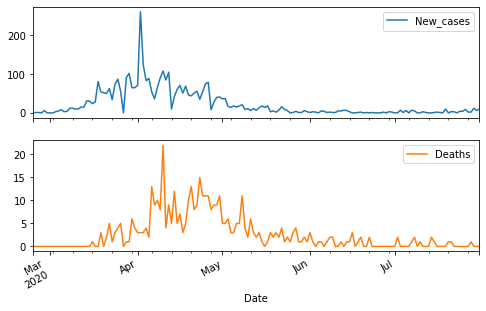

In [9]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,159.0,22.817610,34.652498,0.0,1.0,7.0,35.5,261.0
Deaths,159.0,2.622642,3.742806,0.0,0.0,1.0,3.5,22.0


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
# Create a window for a single prediction 7 days
# into the future, given 14 days of history
w1 = WindowGenerator(input_width=14, label_width=1, shift=7,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[compart])
w1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [20]
Label column name(s): ['New_cases']

In [14]:
# Creates a window for a single one-day prediction
# into the future, given 14 days of history
w2 = WindowGenerator(input_width=30, label_width=1, shift=1,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[compart])
w2

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['New_cases']

In [15]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[20:20+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

In [16]:
w2._example = example_inputs, example_labels

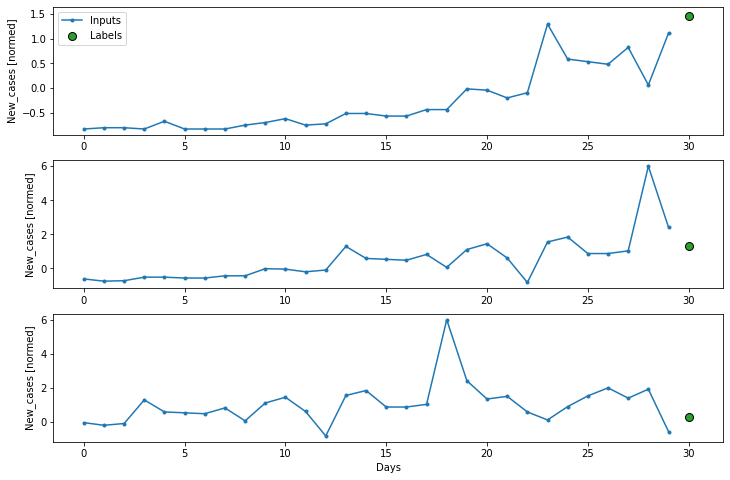

In [17]:
w2.plot()

In [18]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

## Single step

In [19]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [20]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError(),
                          tf.metrics.MeanAbsolutePercentageError()])

val_performance = {}
performance = {}

In [21]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0582 - mean_squared_error: 0.0064 - mean_absolute_percentage_error: 7.7714


In [22]:
performance['Baseline'] = baseline.evaluate(single_step_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0211 - mean_absolute_error: 0.1116 - mean_squared_error: 0.0211 - mean_absolute_percentage_error: 17.1707


### Wide window

In [23]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['New_cases']

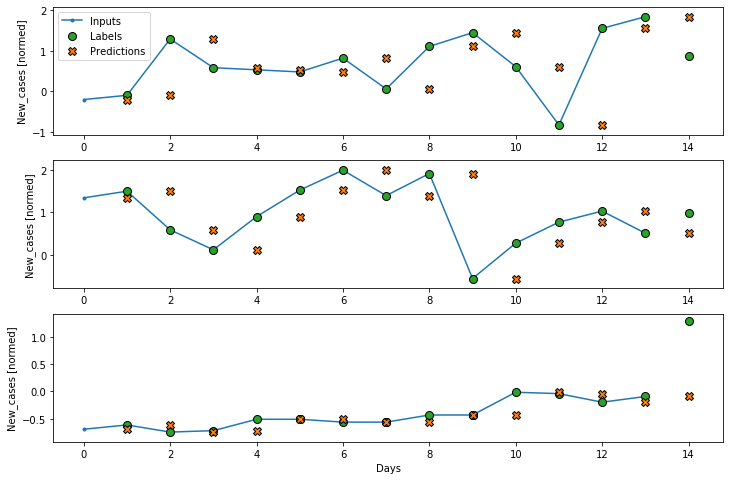

In [24]:
wide_window.plot(baseline)

In [25]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [26]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 55ms/step - loss: 1.5391 - mean_absolute_error: 0.9179 - mean_squared_error: 1.5391 - mean_absolute_percentage_error: 133.1506 - val_loss: 0.8133 - val_mean_absolute_error: 0.8979 - val_mean_squared_error: 0.8133 - val_mean_absolute_percentage_error: 114.1393
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.5307 - mean_absolute_error: 0.9152 - mean_squared_error: 1.5307 - mean_absolute_percentage_error: 133.2644 - val_loss: 0.8041 - val_mean_absolute_error: 0.8928 - val_mean_squared_error: 0.8041 - val_mean_absolute_percentage_error: 113.4798
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 1.5228 - mean_absolute_error: 0.9126 - mean_squared_error: 1.5228 - mean_absolute_percentage_error: 133.4123 - val_loss: 0.7972 - val_mean_absolute_error: 0.8889 - val_mean_squared_error: 0.7972 - val_mean_absolute_percentage_error: 112.9800
Epoch 4/50
4/4 [==============================] - 0s 18ms/ste

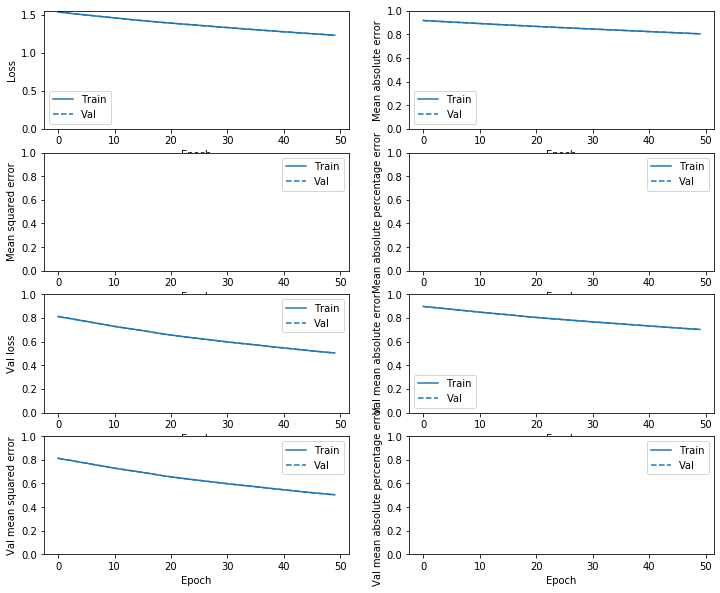

In [27]:
plot_metrics(history)

In [28]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.5046 - mean_absolute_error: 0.7036 - mean_squared_error: 0.5046 - mean_absolute_percentage_error: 89.3455


In [29]:
performance['Linear'] = linear.evaluate(single_step_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.3429 - mean_absolute_error: 0.5760 - mean_squared_error: 0.3429 - mean_absolute_percentage_error: 80.7679


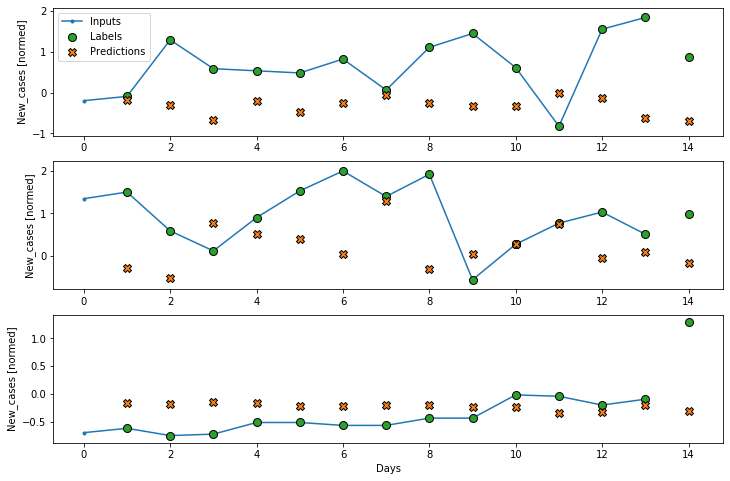

In [30]:
wide_window.plot(linear)

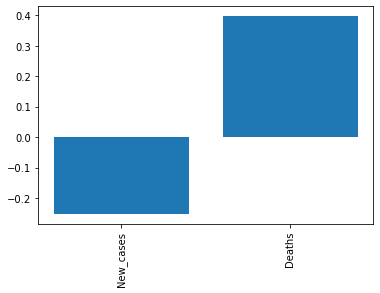

In [31]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [32]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 66ms/step - loss: 0.7238 - mean_absolute_error: 0.5895 - mean_squared_error: 0.7238 - mean_absolute_percentage_error: 87.1063 - val_loss: 0.2141 - val_mean_absolute_error: 0.4589 - val_mean_squared_error: 0.2141 - val_mean_absolute_percentage_error: 58.0444
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.6155 - mean_absolute_error: 0.4908 - mean_squared_error: 0.6155 - mean_absolute_percentage_error: 86.2401 - val_loss: 0.1075 - val_mean_absolute_error: 0.3214 - val_mean_squared_error: 0.1075 - val_mean_absolute_percentage_error: 40.4994
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 0.5640 - mean_absolute_error: 0.4262 - mean_squared_error: 0.5640 - mean_absolute_percentage_error: 91.3371 - val_loss: 0.0411 - val_mean_absolute_error: 0.1908 - val_mean_squared_error: 0.0411 - val_mean_absolute_percentage_error: 23.8233
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - lo

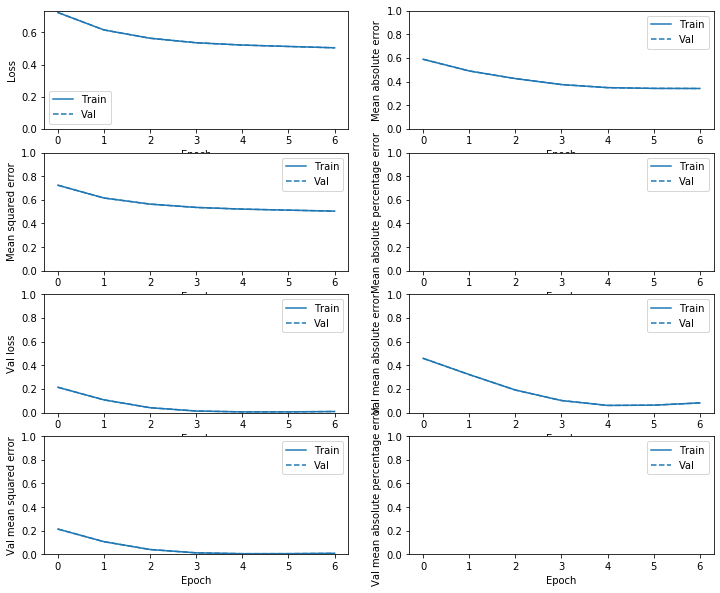

In [33]:
plot_metrics(history)

In [34]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0818 - mean_squared_error: 0.0090 - mean_absolute_percentage_error: 10.4336


In [35]:
performance['Dense'] = dense.evaluate(single_step_window.test)

1/1 [==============================] - 0s 995us/step - loss: 0.0206 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0206 - mean_absolute_percentage_error: 17.2899


In [36]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['New_cases']

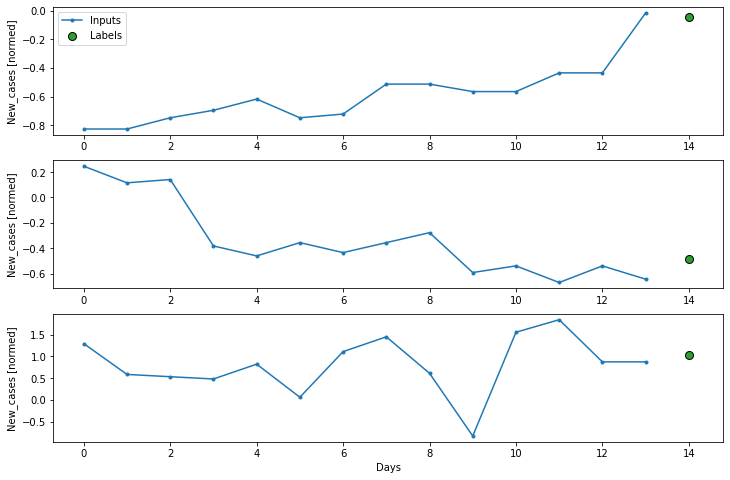

In [37]:
conv_window.plot()

In [38]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [39]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/50
4/4 [==============================] - 0s 50ms/step - loss: 1.2182 - mean_absolute_error: 0.8679 - mean_squared_error: 1.2182 - mean_absolute_percentage_error: 158.1388 - val_loss: 0.6284 - val_mean_absolute_error: 0.7865 - val_mean_squared_error: 0.6284 - val_mean_absolute_percentage_error: 101.6072
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 1.0060 - mean_absolute_error: 0.7337 - mean_squared_error: 1.0060 - mean_absolute_percentage_error: 114.7322 - val_loss: 0.3510 - val_mean_absolute_error: 0.5860 - val_mean_squared_error: 0.3510 - val_mean_absolute_percentage_error: 75.5429
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 0.8848 - mean_absolute_error: 0.6438 - mean_squared_error: 0.8848 - mean_absolute_percentage_error: 110.8869 - val_loss: 0.1996 - val_mean_absolute_error: 0.4388 - val_mean_squared_error: 0.1996 - val_mean_absolute_percentage_error: 56.4033
Epoch 4/50
4/4 [==============================] - 0s 18ms/step 

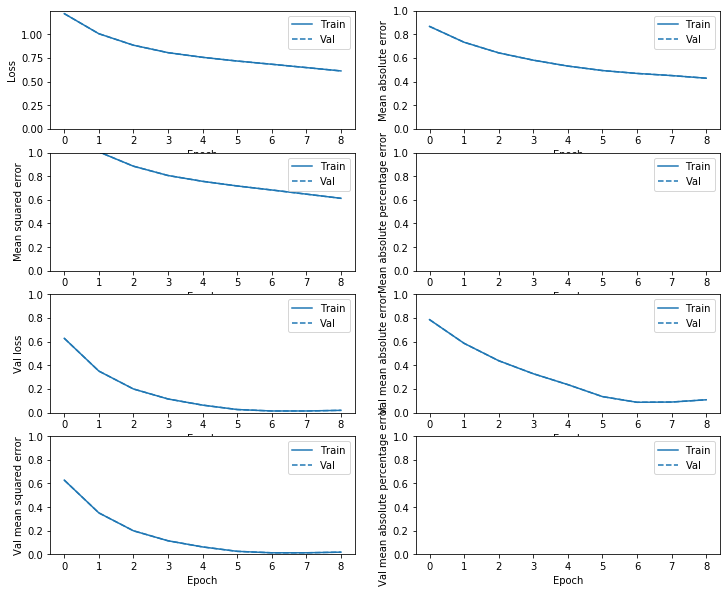

In [40]:
plot_metrics(history)

In [41]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0189 - mean_absolute_error: 0.1084 - mean_squared_error: 0.0189 - mean_absolute_percentage_error: 13.6420


In [42]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0805 - mean_squared_error: 0.0078 - mean_absolute_percentage_error: 12.6426


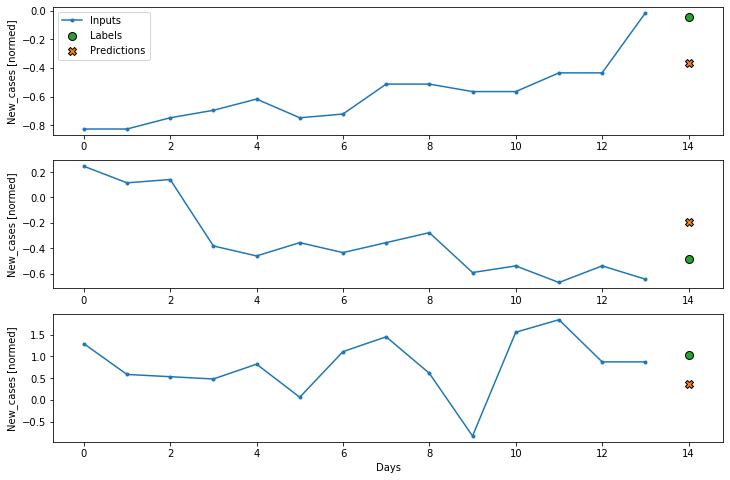

In [43]:
conv_window.plot(multi_step_dense)

In [44]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [45]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 159ms/step - loss: 0.8286 - mean_absolute_error: 0.6359 - mean_squared_error: 0.8286 - mean_absolute_percentage_error: 87.3258 - val_loss: 0.3546 - val_mean_absolute_error: 0.5889 - val_mean_squared_error: 0.3546 - val_mean_absolute_percentage_error: 74.9859
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.7617 - mean_absolute_error: 0.5926 - mean_squared_error: 0.7617 - mean_absolute_percentage_error: 88.9139 - val_loss: 0.2629 - val_mean_absolute_error: 0.4989 - val_mean_squared_error: 0.2629 - val_mean_absolute_percentage_error: 63.3287
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: 0.7121 - mean_absolute_error: 0.5541 - mean_squared_error: 0.7121 - mean_absolute_percentage_error: 92.9148 - val_loss: 0.1933 - val_mean_absolute_error: 0.4130 - val_mean_squared_error: 0.1933 - val_mean_absolute_percentage_error: 52.2091
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - l

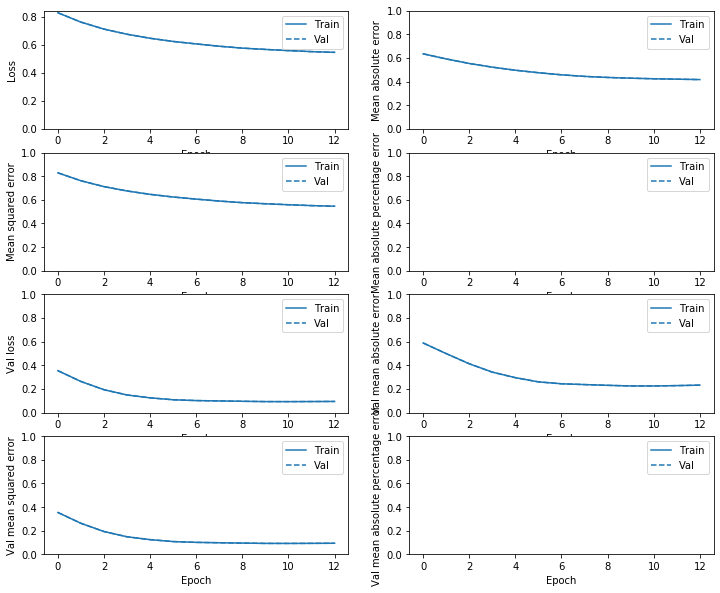

In [46]:
plot_metrics(history)

In [47]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0942 - mean_absolute_error: 0.2321 - mean_squared_error: 0.0942 - mean_absolute_percentage_error: 29.1548


In [48]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0912 - mean_absolute_error: 0.2370 - mean_squared_error: 0.0912 - mean_absolute_percentage_error: 32.1184


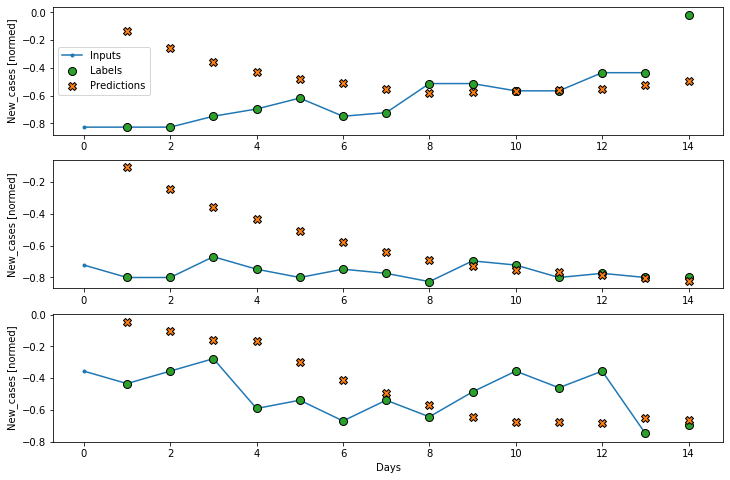

In [49]:
wide_window.plot(lstm_model)

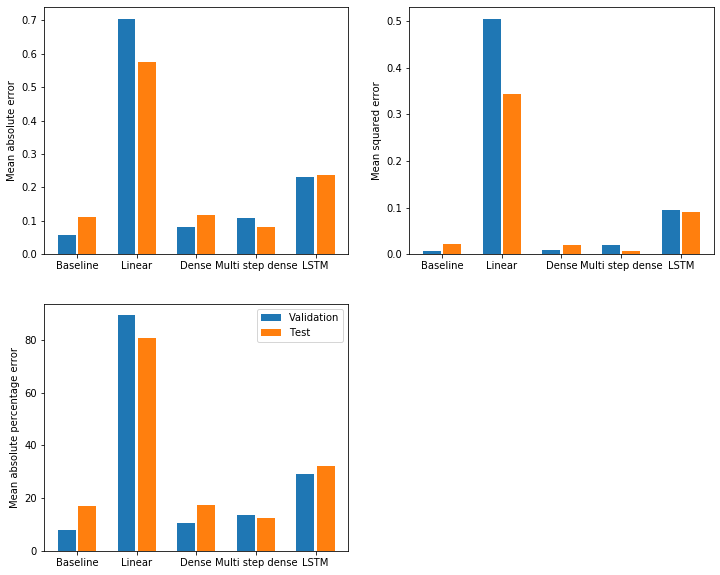

In [50]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

### Multi-output

In [51]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [52]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError(),
                          tf.metrics.MeanAbsolutePercentageError()])

In [53]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0400 - mean_absolute_error: 0.1137 - mean_squared_error: 0.0400 - mean_absolute_percentage_error: 19.7740


In [54]:
performance['Baseline'] = baseline.evaluate(wide_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0195 - mean_absolute_error: 0.0921 - mean_squared_error: 0.0195 - mean_absolute_percentage_error: 13.6086


In [55]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [56]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 60ms/step - loss: 1.1132 - mean_absolute_error: 0.7967 - mean_squared_error: 1.1132 - mean_absolute_percentage_error: 112.1962 - val_loss: 0.4546 - val_mean_absolute_error: 0.6552 - val_mean_squared_error: 0.4546 - val_mean_absolute_percentage_error: 85.2473
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 0.9385 - mean_absolute_error: 0.7116 - mean_squared_error: 0.9385 - mean_absolute_percentage_error: 96.4100 - val_loss: 0.3337 - val_mean_absolute_error: 0.5561 - val_mean_squared_error: 0.3337 - val_mean_absolute_percentage_error: 71.5683
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.8165 - mean_absolute_error: 0.6420 - mean_squared_error: 0.8165 - mean_absolute_percentage_error: 86.8717 - val_loss: 0.2335 - val_mean_absolute_error: 0.4578 - val_mean_squared_error: 0.2335 - val_mean_absolute_percentage_error: 58.8741
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - l

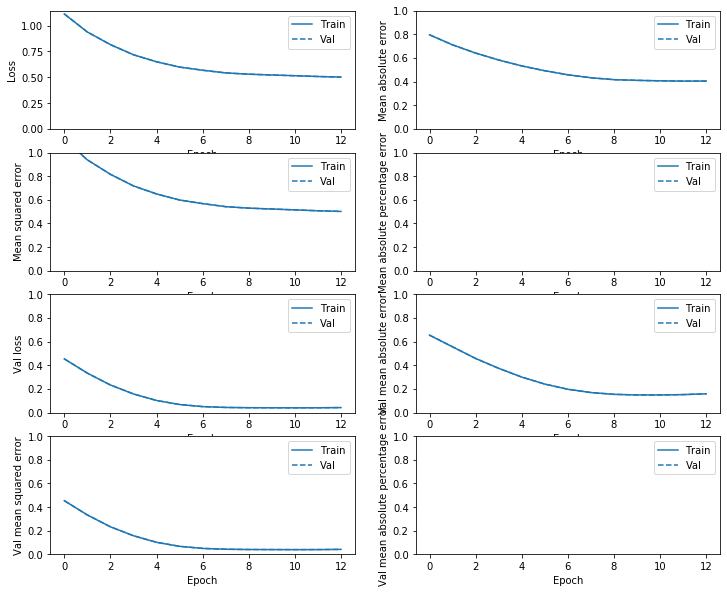

In [57]:
plot_metrics(history)

In [58]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0423 - mean_absolute_error: 0.1587 - mean_squared_error: 0.0423 - mean_absolute_percentage_error: 28.8857


In [59]:
performance['Dense'] = dense.evaluate(single_step_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0173 - mean_absolute_error: 0.1114 - mean_squared_error: 0.0173 - mean_absolute_percentage_error: 14.9866


In [64]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 196ms/step - loss: 0.9651 - mean_absolute_error: 0.7200 - mean_squared_error: 0.9651 - mean_absolute_percentage_error: 95.2525 - val_loss: 0.5127 - val_mean_absolute_error: 0.7018 - val_mean_squared_error: 0.5127 - val_mean_absolute_percentage_error: 90.0205
Epoch 2/50
4/4 [==============================] - 0s 23ms/step - loss: 0.9050 - mean_absolute_error: 0.6897 - mean_squared_error: 0.9050 - mean_absolute_percentage_error: 90.7970 - val_loss: 0.4504 - val_mean_absolute_error: 0.6552 - val_mean_squared_error: 0.4504 - val_mean_absolute_percentage_error: 83.7051
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 0.8562 - mean_absolute_error: 0.6624 - mean_squared_error: 0.8562 - mean_absolute_percentage_error: 88.5871 - val_loss: 0.4056 - val_mean_absolute_error: 0.6188 - val_mean_squared_error: 0.4056 - val_mean_absolute_percentage_error: 78.7358
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - l

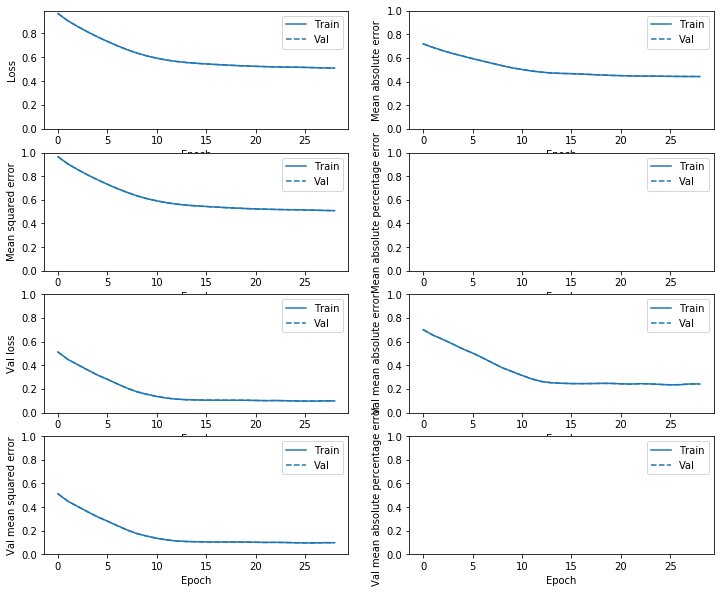

In [65]:
plot_metrics(history)

In [66]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0987 - mean_absolute_error: 0.2422 - mean_squared_error: 0.0987 - mean_absolute_percentage_error: 33.9260


In [67]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0874 - mean_absolute_error: 0.2198 - mean_squared_error: 0.0874 - mean_absolute_percentage_error: 28.3841


In [68]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 142ms/step - loss: 0.7492 - mean_absolute_error: 0.4835 - mean_squared_error: 0.7492 - mean_absolute_percentage_error: 138.5695 - val_loss: 0.0399 - val_mean_absolute_error: 0.1163 - val_mean_squared_error: 0.0399 - val_mean_absolute_percentage_error: 19.9889
Epoch 2/50
4/4 [==============================] - 0s 23ms/step - loss: 0.7470 - mean_absolute_error: 0.4842 - mean_squared_error: 0.7470 - mean_absolute_percentage_error: 138.0994 - val_loss: 0.0400 - val_mean_absolute_error: 0.1188 - val_mean_squared_error: 0.0400 - val_mean_absolute_percentage_error: 20.1955
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 0.7450 - mean_absolute_error: 0.4847 - mean_squared_error: 0.7450 - mean_absolute_percentage_error: 137.6919 - val_loss: 0.0402 - val_mean_absolute_error: 0.1212 - val_mean_squared_error: 0.0402 - val_mean_absolute_percentage_error: 20.3932


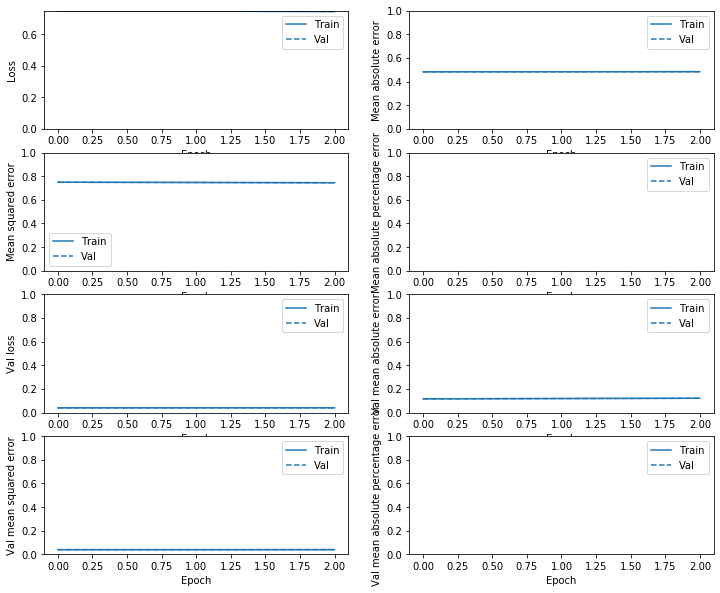

In [69]:
plot_metrics(history)

In [70]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0402 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0402 - mean_absolute_percentage_error: 20.3932


In [71]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0196 - mean_absolute_error: 0.0998 - mean_squared_error: 0.0196 - mean_absolute_percentage_error: 14.3316


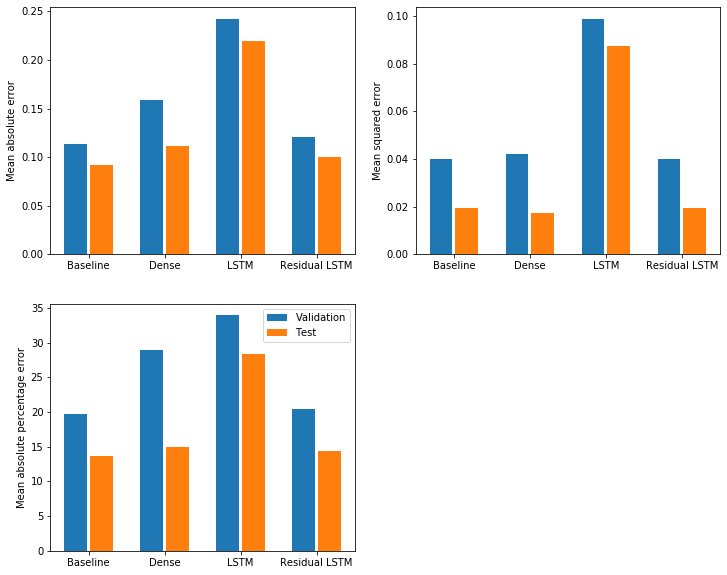

In [72]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

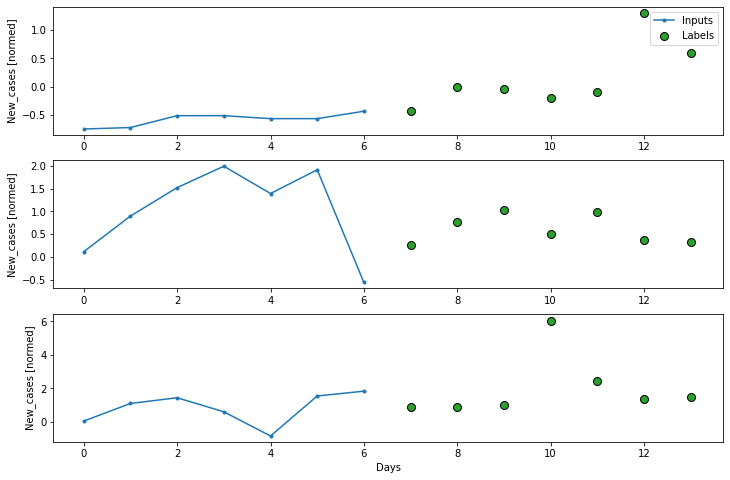

In [95]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot()

In [96]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError(),
                          tf.metrics.MeanAbsolutePercentageError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0350 - mean_absolute_error: 0.1056 - mean_squared_error: 0.0350 - mean_absolute_percentage_error: 17.4596


In [97]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 11.7187


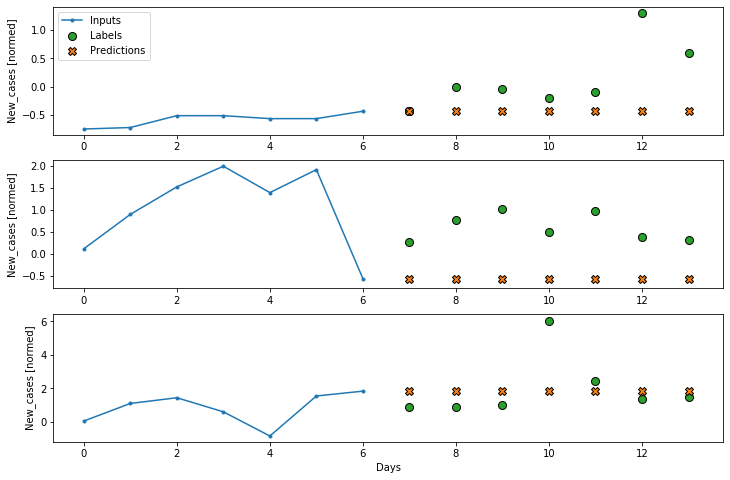

In [98]:
multi_window.plot(last_baseline)

In [99]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError(),
                          tf.metrics.MeanAbsolutePercentageError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0459 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0459 - mean_absolute_percentage_error: 20.4070


In [100]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0114 - mean_absolute_error: 0.0653 - mean_squared_error: 0.0114 - mean_absolute_percentage_error: 9.8068


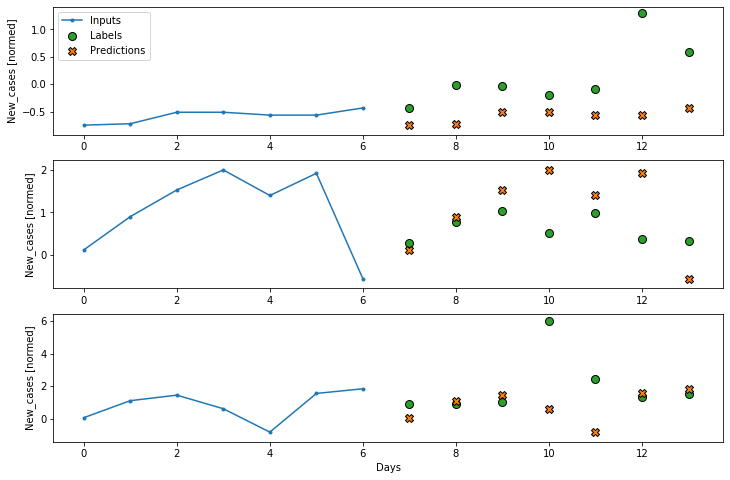

In [101]:
multi_window.plot(repeat_baseline)

### Single shot

In [102]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 56ms/step - loss: 1.0347 - mean_absolute_error: 0.7546 - mean_squared_error: 1.0347 - mean_absolute_percentage_error: 99.8195 - val_loss: 0.6115 - val_mean_absolute_error: 0.7711 - val_mean_squared_error: 0.6115 - val_mean_absolute_percentage_error: 99.5056
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 1.0276 - mean_absolute_error: 0.7514 - mean_squared_error: 1.0276 - mean_absolute_percentage_error: 99.1684 - val_loss: 0.6051 - val_mean_absolute_error: 0.7669 - val_mean_squared_error: 0.6051 - val_mean_absolute_percentage_error: 98.9388
Epoch 3/50
4/4 [==============================] - 0s 15ms/step - loss: 1.0206 - mean_absolute_error: 0.7481 - mean_squared_error: 1.0206 - mean_absolute_percentage_error: 98.4496 - val_loss: 0.5970 - val_mean_absolute_error: 0.7616 - val_mean_squared_error: 0.5970 - val_mean_absolute_percentage_error: 98.2227
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - lo

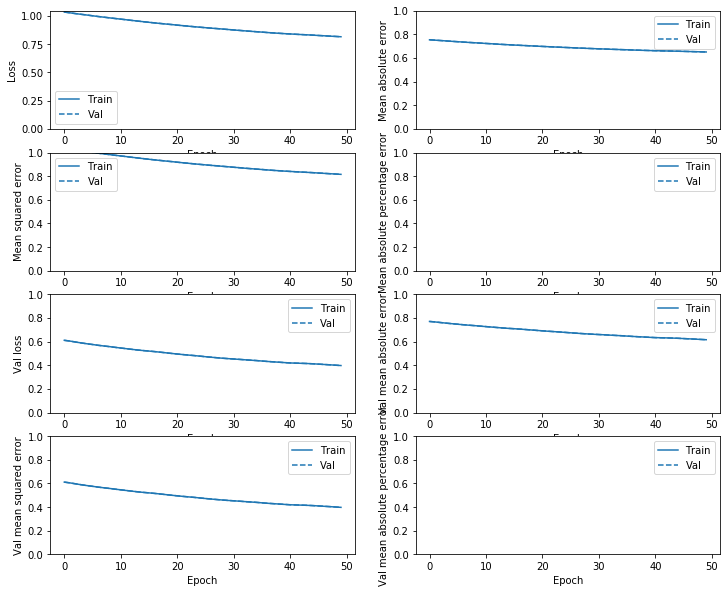

In [103]:
plot_metrics(history)

In [104]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.3980 - mean_absolute_error: 0.6165 - mean_squared_error: 0.3980 - mean_absolute_percentage_error: 78.5369


In [105]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test)

1/1 [==============================] - 0s 1ms/step - loss: 0.3577 - mean_absolute_error: 0.5890 - mean_squared_error: 0.3577 - mean_absolute_percentage_error: 77.7524


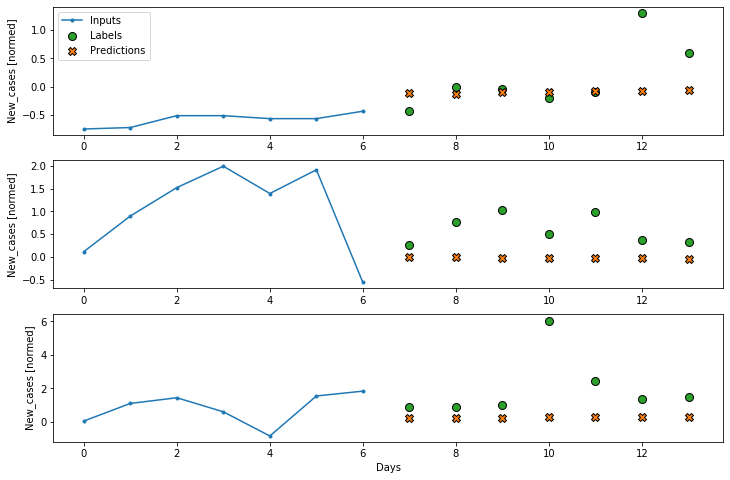

In [106]:
multi_window.plot(multi_linear_model)

In [107]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 62ms/step - loss: 1.0166 - mean_absolute_error: 0.7458 - mean_squared_error: 1.0166 - mean_absolute_percentage_error: 98.1409 - val_loss: 0.5492 - val_mean_absolute_error: 0.7295 - val_mean_squared_error: 0.5492 - val_mean_absolute_percentage_error: 93.8591
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.9452 - mean_absolute_error: 0.7102 - mean_squared_error: 0.9452 - mean_absolute_percentage_error: 93.3157 - val_loss: 0.4801 - val_mean_absolute_error: 0.6803 - val_mean_squared_error: 0.4801 - val_mean_absolute_percentage_error: 87.1781
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.8809 - mean_absolute_error: 0.6784 - mean_squared_error: 0.8809 - mean_absolute_percentage_error: 92.4549 - val_loss: 0.4185 - val_mean_absolute_error: 0.6330 - val_mean_squared_error: 0.4185 - val_mean_absolute_percentage_error: 80.7633
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - lo

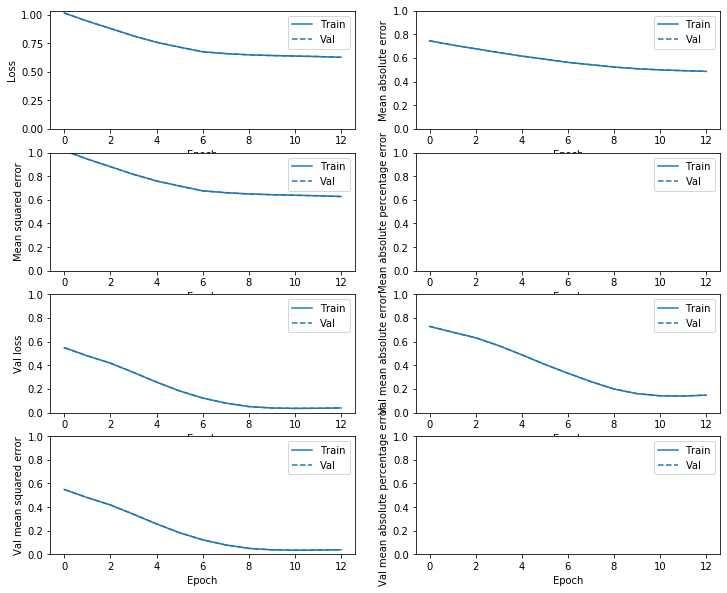

In [108]:
plot_metrics(history)

In [109]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0392 - mean_absolute_error: 0.1478 - mean_squared_error: 0.0392 - mean_absolute_percentage_error: 22.4794


In [110]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0904 - mean_squared_error: 0.0138 - mean_absolute_percentage_error: 12.8124


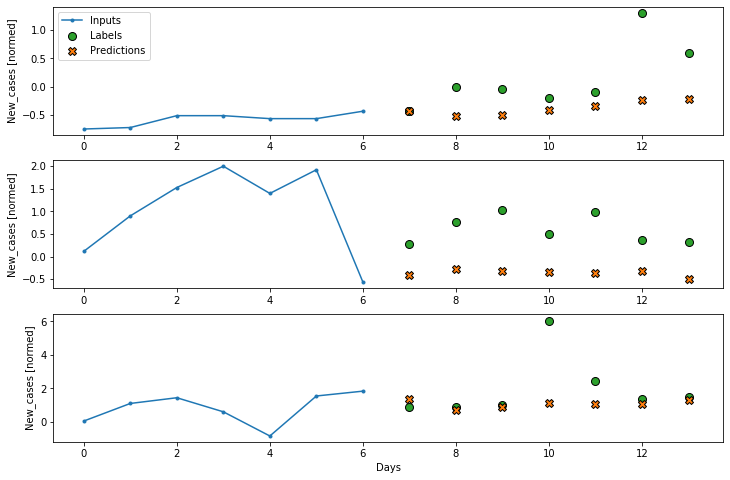

In [111]:
multi_window.plot(multi_dense_model)

In [114]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/50
4/4 [==============================] - 1s 147ms/step - loss: 1.0332 - mean_absolute_error: 0.7538 - mean_squared_error: 1.0332 - mean_absolute_percentage_error: 99.6693 - val_loss: 0.5997 - val_mean_absolute_error: 0.7634 - val_mean_squared_error: 0.5997 - val_mean_absolute_percentage_error: 98.4532
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.0162 - mean_absolute_error: 0.7455 - mean_squared_error: 1.0162 - mean_absolute_percentage_error: 97.9316 - val_loss: 0.5779 - val_mean_absolute_error: 0.7489 - val_mean_squared_error: 0.5779 - val_mean_absolute_percentage_error: 96.4879
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.9980 - mean_absolute_error: 0.7361 - mean_squared_error: 0.9980 - mean_absolute_percentage_error: 96.4353 - val_loss: 0.5516 - val_mean_absolute_error: 0.7311 - val_mean_squared_error: 0.5516 - val_mean_absolute_percentage_error: 94.0702
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - l

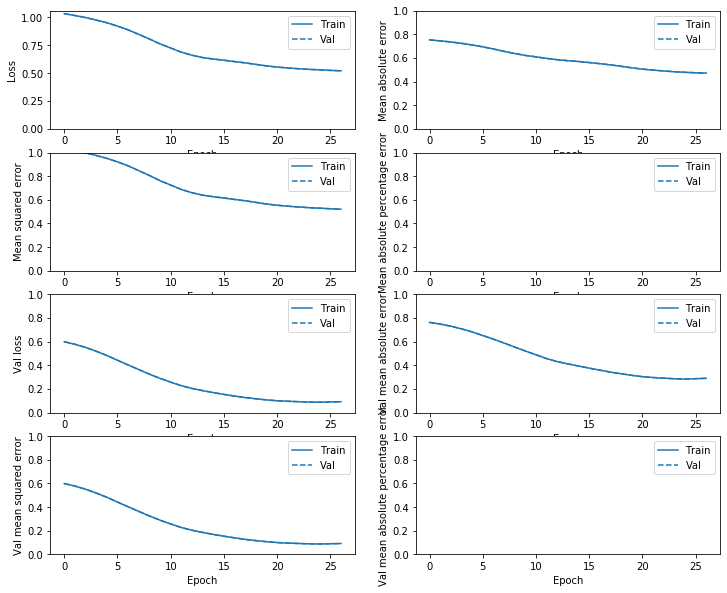

In [115]:
plot_metrics(history)

In [116]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0919 - mean_absolute_error: 0.2899 - mean_squared_error: 0.0919 - mean_absolute_percentage_error: 37.3073


In [117]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

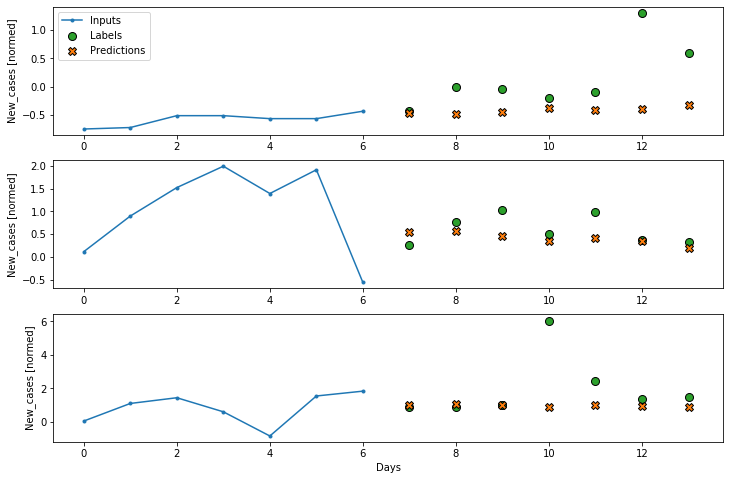

In [118]:
multi_window.plot(multi_lstm_model)

## AR model

In [121]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [122]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [123]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 114ms/step - loss: 1.0305 - mean_absolute_error: 0.7519 - mean_squared_error: 1.0305 - mean_absolute_percentage_error: 98.6905 - val_loss: 0.5884 - val_mean_absolute_error: 0.7554 - val_mean_squared_error: 0.5884 - val_mean_absolute_percentage_error: 97.5713
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.9498 - mean_absolute_error: 0.7168 - mean_squared_error: 0.9498 - mean_absolute_percentage_error: 94.7510 - val_loss: 0.5215 - val_mean_absolute_error: 0.7099 - val_mean_squared_error: 0.5215 - val_mean_absolute_percentage_error: 91.3938
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8721 - mean_absolute_error: 0.6820 - mean_squared_error: 0.8721 - mean_absolute_percentage_error: 94.7373 - val_loss: 0.4460 - val_mean_absolute_error: 0.6546 - val_mean_squared_error: 0.4460 - val_mean_absolute_percentage_error: 83.8967
Epoch 4/50
4/4 [==============================] - 0s 23ms/step - l

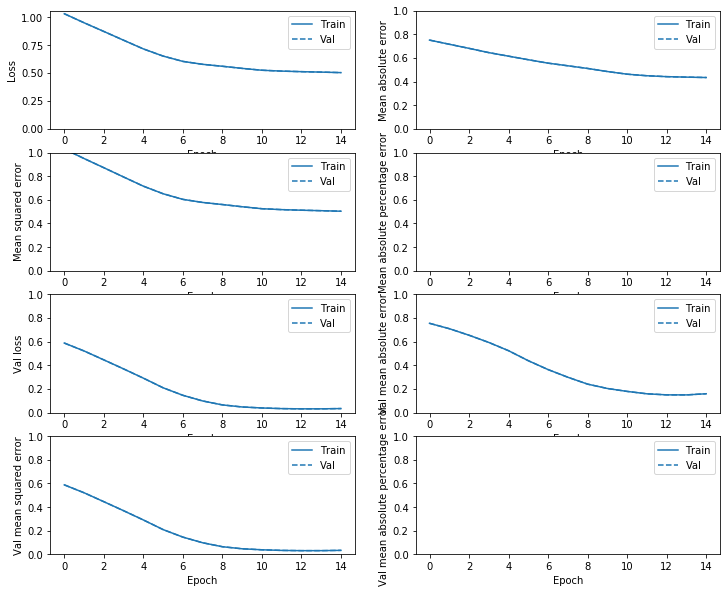

In [124]:
plot_metrics(history)

In [125]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0340 - mean_absolute_error: 0.1593 - mean_squared_error: 0.0340 - mean_absolute_percentage_error: 23.1562


In [126]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

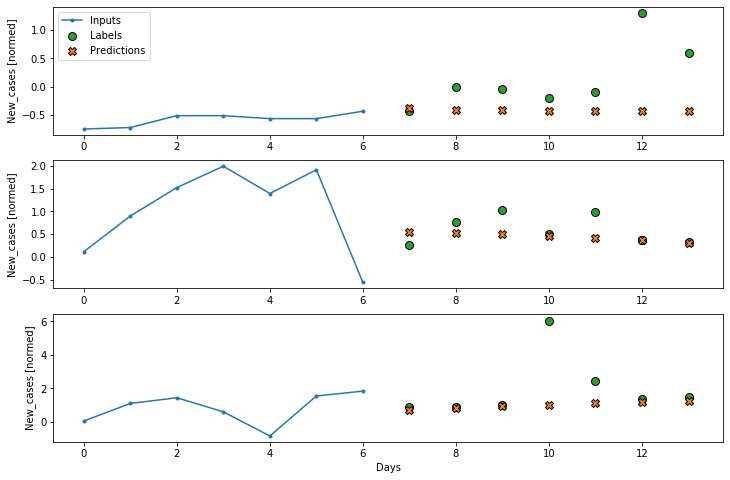

In [127]:
multi_window.plot(feedback_model)

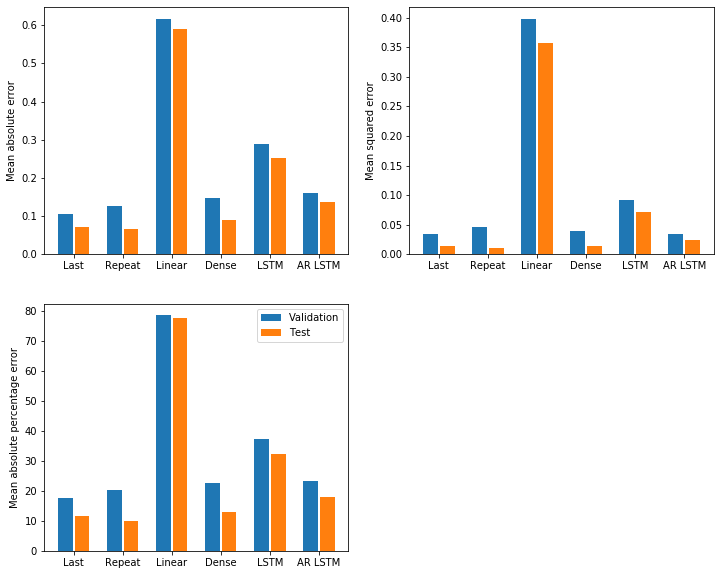

In [129]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance)